In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import os, os.path
import cv2

# Prepare Dataset

In [3]:
# show images in a row
def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(11,8))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = list_of_files[i]
        imshow(image,cmap='Greys_r')
        axis('off')

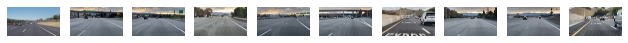

In [4]:
# show all pictures (./test_images)
all_imgs = []
path = "test_images/"
valid_images = [".jpg",".gif",".png",".tga"]
for file_name in os.listdir(path):
    if file_name != ".DS_Store":
        one_image = mpimg.imread('test_images/'+file_name)
        all_imgs.append(one_image)

showImagesHorizontally(all_imgs)

# Step 1. Color Selection
- An image contains three colors (R, G, B): Blue (0, 0, 255); Red(255, 0, 0); Green(0, 255, 0).
- We want to use color selection to find traffic line that, in the most of time, are usually white (255, 255, 255). 

In [5]:
def colorSelection(image):
    heigth = image.shape[0]
    width = image.shape[1]
#     print("the shape of the image is: ", image.shape)
    
    # make a copy of this image
    output_img = np.copy(image)
    
    # set the threshold for three colors
    th_red = 170
    th_gre = 170
    th_blu = 170

    th_rgb = [th_gre, th_gre, th_blu]
    # threshold is a boolen matrix. if one of pixal is true, it will be reset to black
    thresholds = (image[:,:,0] < th_rgb[0]) | (image[:,:,1] < th_rgb[1]) | (image[:,:,2] < th_rgb[2])    
    
    output_img[thresholds] = [0,0,0]
    return output_img

In [6]:
def showResult(arr_num, all_imgs):
    for i in arr_num:
        image = all_imgs[i]
        output = colorSelection(image)
        imgs_list = [image, output]
        showImagesHorizontally(imgs_list)

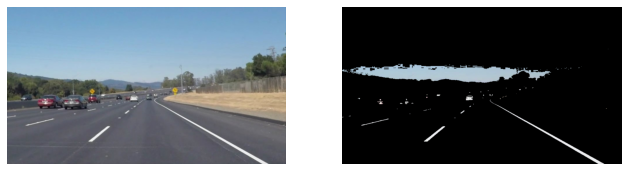

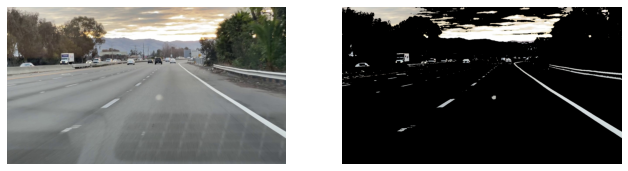

In [7]:
showResult([0, 3], all_imgs)

# Step 2: Area Attention

Since a camera that take the images/videos is mounted in a fixed position on the front of the car, we can assume that the traffic line appears in the 3/4 region of the image.

In [8]:
def colorSelectionAttention(image, attention_line):
    height = image.shape[0]
    width = image.shape[1]
    
    # make a copy of this image
    output_img = np.copy(image)
    
    # set the threshold for three colors
    th_red = 170
    th_gre = 170
    th_blu = 170

    th_rgb = [th_gre, th_gre, th_blu]   
    thresholds = (image[:,:,0] < th_rgb[0]) | (image[:,:,1] < th_rgb[1]) | (image[:,:,2] < th_rgb[2])    
    
    # set the area of attention
    blank = np.ones((attention_line, width), dtype=bool)
    attention = np.zeros((height-attention_line, width), dtype=bool)
    mask =np.append(blank, attention,  axis=0)
    
    output_img[thresholds] = [0,0,0]
    output_img[mask] = [0,0,0]
    return output_img

In [9]:
def showResult2(attention_line, arr_num, all_imgs):
    for i in arr_num:
        image = all_imgs[i]
        output = colorSelectionAttention(image, attention_line)
        output_without_attention = colorSelection(image)
        
        # 1. draw attention area
        plt.imshow(image)
        rect = patches.Rectangle((1, attention_line), 1279, 476, linewidth=4, edgecolor='r',linestyle='--', facecolor='none')
        plt.gca().add_patch(rect)
        axis('off')
        plt.title("Area Of Attention")
        plt.show() 
        
        
        imgs_list = [output_without_attention, output]
        showImagesHorizontally(imgs_list)

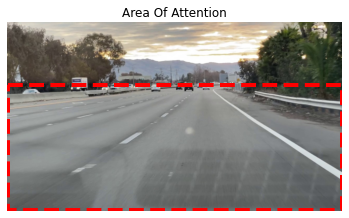

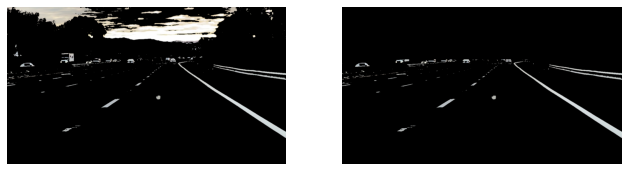

In [10]:
showResult2(240, [3], all_imgs)

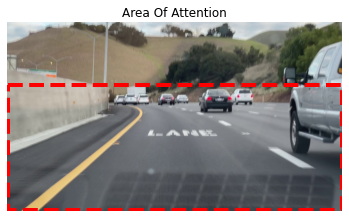

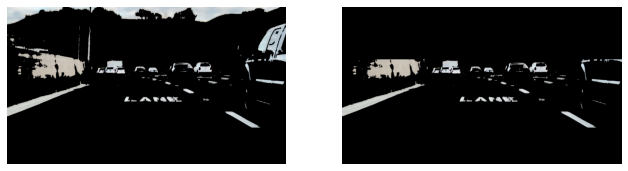

In [12]:
showResult2(240, [9], all_imgs)

# Step 3: Canny Edge Detection

In [13]:
def cannyEdgeDetection(image):
    # convert an rgb image to grayscle image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 180
    high_threshold = 100
    edges_image = cv2.Canny(blur_gray, low_threshold, high_threshold)
    return edges_image

In [14]:
def showResult3(arr_num, all_imgs):
    for i in arr_num:
        image = all_imgs[i]
        output = cannyEdgeDetection(image)
        imgs_list = [image, output]
        showImagesHorizontally(imgs_list)

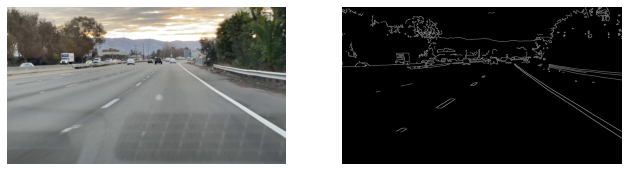

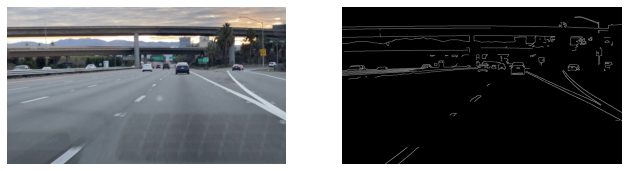

In [15]:
showResult3([3, 5], all_imgs)

# Step 4: Hough Transform

In [36]:
def houghTransform(image):
    # convert an rgb image to grayscle image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 #Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 180
    high_threshold = 100
    edges_image = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges_image) 
    ignore_mask_color = 255   

    # creating a attention mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(1, 260), (1279, 260), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges_image, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 2     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 4 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    
    # generating a new black screen that allow to draw traffic lines and attention area.
    line_image = np.copy(image)*0 
    

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    
    # Draw traffic lines on the mask image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),7)

    # three layer color_edges, color edge is the Canny image
    color_edges = np.dstack((edges_image, edges_image, edges_image)) 

    # Draw the lines on the edge image!
    # cv2.addWeighted(src1, alpha, src2, beta, gamma[, dst[, dtype]])
    lines_edges = cv2.addWeighted(color_edges, 0.9, line_image, 1, 0)
    
    # Draw the attention area on the image   
    lines_edges = cv2.polylines(lines_edges, vertices, True, (0,0,255), 10)
    
    
    plt.imshow(image)
    plt.title("Input Image")
    plt.show()
    
    plt.imshow(lines_edges)
    plt.title("Red Traffic Line and Blue Attention Area")
    plt.show()
    
    plt.imshow(line_image)
    plt.title("Red Traffic Line")
    plt.show()
    
    return lines

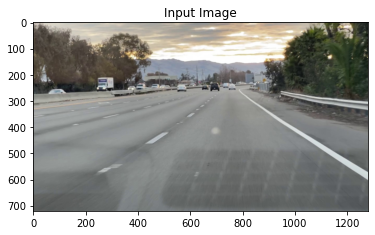

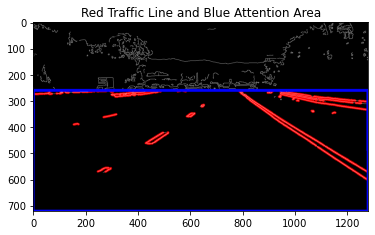

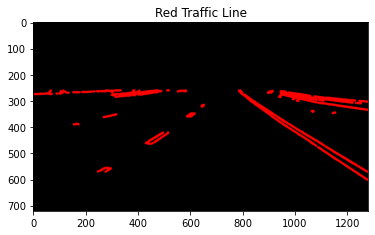

array([[[1221,  537, 1235,  544]],

       [[ 211,  265,  225,  265]],

       [[ 945,  264,  954,  276]],

       ...,

       [[ 611,  352,  617,  347]],

       [[ 993,  280,  997,  280]],

       [[1019,  279, 1021,  274]]], dtype=int32)

In [56]:
houghTransform(all_imgs[3])

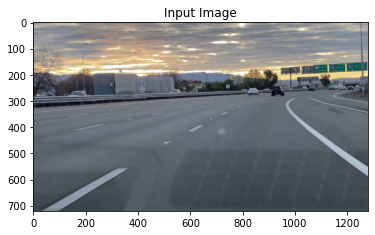

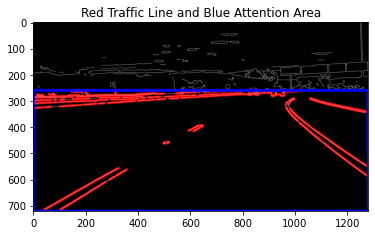

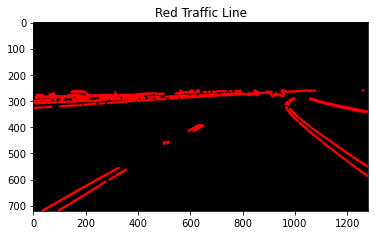

array([[[1071,  294, 1083,  297]],

       [[1006,  263, 1042,  261]],

       [[ 466,  285,  484,  285]],

       ...,

       [[ 985,  334,  995,  344]],

       [[1254,  340, 1258,  337]],

       [[1270,  580, 1275,  584]]], dtype=int32)

In [38]:
houghTransform(all_imgs[4])

In [ ]:
def average_slope_intercept(lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
        Parameters:
            lines: The output lines from Hough Transform.
    """
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    """
    Create full lenght lines from pixel points.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
    """
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line
    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lines onto the input image.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
            color (Default = red): Line color.
            thickness (Default = 12): Line thickness. 
    """
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

# Marking Traffic Lines

In [63]:
positive_slop_arr = []   
negative_slop_arr = []  
for line in lines:
    for x1,y1,x2,y2 in line:
        if (x2-x1) != 0:
            slop = np.float((y2-y1))/np.float((x2-x1))  
        elif slop > 0:                 
            positive_slop_arr.append([slop,y1-slop*x1]) 
        elif slop < 0 :
            negative_slop_arr.append([slop,y1-slop*x1])
            
print("positive_slop_arr: ", positive_slop_arr)
print("positive_slop_arr len: ", len(positive_slop_arr))
print("positive_slop_arr: ", negative_slop_arr)
print("negative_slop_arr len: ", len(negative_slop_arr))

positive_slop_arr:  [[0.4444444444444444, 187.33333333333334], [0.25, 27.0], [2.0, -1848.0], [0.75, -506.0]]
positive_slop_arr len:  4
positive_slop_arr:  [[-0.16666666666666666, 298.3333333333333], [-0.08333333333333333, 337.6666666666667], [-2.0, 357.0], [-0.25, 588.5], [-0.14285714285714285, 313.85714285714283], [-1.0, 1238.0]]
negative_slop_arr len:  6


In [65]:
def slopSelection(slop_intercept):
    legal_slop=[]
    legal_intercept=[]
    slopes=[pair[0] for pair in slop_intercept]
    slop_mean = np.mean(slopes)                    
    slop_std = np.std(slopes)                           
    for pair in slop_intercept:
        if pair[0] - slop_mean < 3 * slop_std:             
            legal_slop.append(pair[0])
            legal_intercept.append(pair[1])
    if not legal_slop:                                 
        legal_slop = slopes
        legal_intercept = [pair[1] for pair in slop_intercept]
    slop = np.mean(legal_slop)
    intercept = np.mean(legal_intercept)
    return intercept

In [66]:
intercept = slopSelection(positive_slop_arr)
print(intercept)

-534.9166666666667


In [68]:
xmin = int((320 - intercept)/slop)
xmax = int((540-intercept)/slop)
print(xmin, xmax)

1068 1343


In [ ]:
def lane_lines(image, lines):
    left_lane = average_slope_intercept(positive_slop_arr)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line